## Pastastore

This notebook shows how to use the `observation` package to create a `PastaStore` from point observations. A `pastastore` is a combination of observations, stresses en `pastas` time series models.

## Content<a id=top></a>
1. [oseries](#oseries)
2. [stresses](#stresses)
3. [create and solve models](#models)
4. [model results](#modelresults)

In [1]:
import pastastore as pst
import pandas as pd
import pastas as ps
from observations import ObsCollection
from observations.io import io_knmi
from observations.observation import KnmiObs

In [2]:
ps.set_log_level('ERROR')

### oseries<a id=oseries></a>

In [3]:
extent = [117850, 117980, 439550, 439700]  # Schoonhoven zuid-west
oc_dino = ObsCollection.from_dino(extent=extent, keep_all_obs=False, verbose=False, cache=True)
oc_dino

,x,y,filename,locatie,filternr,bovenkant_filter,onderkant_filter,maaiveld,meetpunt,metadata_available,obs
name,,,,,,,,,,,
B38B0207-001,117960,439670,,B38B0207,1,NaN,-38.67,-0.87,NaN,True,stand_m_tov_nap remarks 1985-02-28...
B38B0206-001,117893,439652,,B38B0206,1,-2.04,-3.04,-0.08,NaN,True,stand_m_tov_nap remarks 1985-03-28...
B38B0206-002,117893,439652,,B38B0206,2,-14.00,-15.00,-0.08,NaN,True,stand_m_tov_nap remarks 1985-03-28...


In [4]:
# add observations to pastastore
pstore = oc_dino.to_pastastore()

In [5]:
pstore.get_oseries('B38B0206-001')

1985-03-28   -1.15
1985-04-15   -1.02
1985-04-29   -1.13
1985-05-14   -1.12
1985-05-28   -1.17
              ... 
2009-10-28   -1.38
2009-11-13   -1.31
2009-11-27   -1.25
2009-12-14   -1.08
2009-12-28   -1.05
Name: stand_m_tov_nap, Length: 470, dtype: float64

### stresses<a id=stresses></a>

In [6]:
tmin = pstore.oseries['startDate'].min()
tmax = pstore.oseries['endDate'].max()

In [8]:
meteo_vars=('RD', 'EV24')
kinds = ('prec', 'evap')
knmi_oc = ObsCollection.from_knmi(locations=oc_dino, meteo_vars=meteo_vars,
                                  start=[tmin, tmin], end=[tmax,tmax], 
                                  cache=True,
                                  verbose=False)

In [9]:
# add stresses to pastastore
for i, meteo_var in enumerate(meteo_vars):
    knmi_oc[knmi_oc.index.str.startswith(meteo_var)].to_pastastore(pstore, obs_column=meteo_var, 
                                                                   kind=kinds[i], verbose=True)

In [10]:
pstore.stresses

,x,y,STN,YYYYMMDD,RD,SX,filename,kind,EV24
name,,,,,,,,,
RD Groot Ammers,115722.518086,436511.749355,stationsnummer/stationnumber,datum/date (YYYY=jaar/year MM=maand/month DD=d...,24-uur som van de neerslag in m van 08.00 voor...,codecijfer sneeuwdek om 08.00 uur UTC/code for...,,prec,NaN
EV24 Cabauw,122637.550043,442024.536029,NaN,Date (YYYY=year MM=month DD=day);,NaN,NaN,,evap,Potential evapotranspiration (Makkink) (in m);


### create and solve models<a id=models></a>

In [11]:
pstore.create_models(store=True, add_recharge=True, ignore_errors=False);

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.77it/s]


In [12]:
pstore.solve_models()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


### Model results<a id=modelresults></a>

In [13]:
# results from all models
pstore.model_results(progressbar=False)

flopy is installed in c:\users\oebbe\02_python\flopy\flopy


,recharge_A,recharge_n,recharge_a,recharge_f,constant_d,noise_alpha,recharge_A_stderr,recharge_n_stderr,recharge_a_stderr,recharge_f_stderr,constant_d_stderr,noise_alpha_stderr,evp,number of observations used in calibration,memory recharge [days],rfunc recharge,calibration period [days]
B38B0207-001,59.2689,0.876532,8.86419,-0.145603,-1.87749,16.9392,18.9563,0.280391,6.91615,0.396625,0.0686886,3.76771,17.3837,NaN,18.4785,Gamma,2115
B38B0206-001,217.892,0.805394,151.711,-0.355108,-1.62868,60.3757,57.4629,0.057143,64.163,0.154273,0.12723,9.04361,30.9832,NaN,296.625,Gamma,9041
B38B0206-002,118.335,0.660375,58.3967,-0.270755,-0.968101,18.4112,26.732,0.0725235,27.9058,0.150125,0.0700907,2.10531,22.867,NaN,98.1272,Gamma,9041


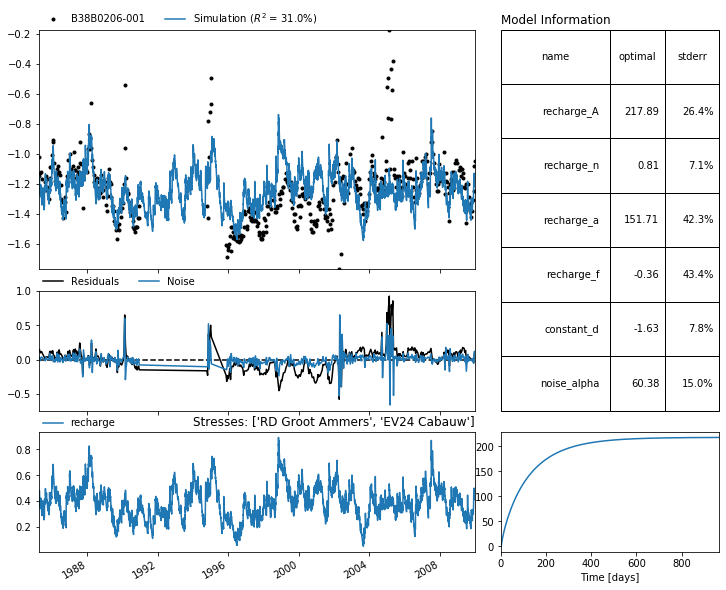

In [14]:
# results from a single model
ml1 = pstore.get_models('B38B0206-001')
ml1.plots.results()